<a href="https://colab.research.google.com/github/soletche/Portfolio_ISRA/blob/main/data_acumulada_AMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# ====================================================
# Diario posiciones + cash (v4.6)
# + Summary metrics (Certificate Position, Currency, RPL) - robust extractor
# ====================================================
!pip install xlsxwriter

import re
from pathlib import Path
from typing import Optional, Dict, List, Tuple
import pandas as pd

BASE_DIR = Path('/content/drive/MyDrive/AMC/python')
OUTPUT_DAILY   = BASE_DIR / 'diario_positions_cash.xlsx'
OUTPUT_SUMMARY = BASE_DIR / 'diario_certificate_position.xlsx'

ALIAS = {
    'ETF': ['ETF','ETFs','Holdings','Positions'],
    'Summary': ['Summary','Resumen','SUM'],
    'Cash': ['Cash','CAJA','Efectivo'],
}

DISCLAIMER_PAT = re.compile(r'(your responsibility|source and basis|risk system values|ubs)', flags=re.I)

# ---------- helpers ----------
def norm(s: str) -> str:
    s = str(s).replace('\n',' ')
    s = re.sub(r'\s+',' ', s).strip()
    return s

def norm_cmp(s: str) -> str:
    s = norm(s).lower()
    s = re.sub(r'[\^\(\)\.\,\:\;\%\-\_]', '', s)
    return s

DATE_PATS = [
    r'(20\d{2})[-_\.](\d{2})[-_\.](\d{2})',
    r'(20\d{2})(\d{2})(\d{2})',
    r'(\d{2})[-_\.](\d{2})[-_\.](20\d{2})',
]
def date_from_name(name: str):
    low = name.lower()
    for pat in DATE_PATS:
        m = re.search(pat, low)
        if m:
            a,b,c = map(int, m.groups())
            if a>1900 and b<=12 and c<=31:
                return pd.Timestamp(a,b,c)
            if c>1900 and b<=12 and a<=31:
                return pd.Timestamp(c,b,a)
    return pd.NaT

def find_sheet(xl: pd.ExcelFile, names: List[str]) -> Optional[str]:
    avail = {s.lower(): s for s in xl.sheet_names}
    for n in names:
        if n.lower() in avail: return avail[n.lower()]
    for n in names:
        for s in xl.sheet_names:
            if n.lower() in s.lower(): return s
    return None

# ---------- table parsing (unchanged from v4.5) ----------
def find_header_row(df_raw: pd.DataFrame, need: List[str], any_of: List[str]) -> Optional[int]:
    for i in range(min(400, len(df_raw))):
        row = [norm_cmp(x) for x in df_raw.iloc[i].tolist()]
        if all(k in row for k in need) and any(any(k in cell for k in any_of) for cell in row):
            return i
    return None

def cut_table(df_raw: pd.DataFrame, header_idx: int) -> pd.DataFrame:
    header = [norm(x) for x in df_raw.iloc[header_idx].tolist()]
    df = df_raw.iloc[header_idx+1:].copy()
    df.columns = header
    for j in range(header_idx+1, len(df_raw)):
        a = str(df_raw.iloc[j,0]).strip()
        if (a == "" or a.upper() in ("USD","EUR","GBP") or a.startswith("**") or DISCLAIMER_PAT.search(a)):
            df = df_raw.iloc[header_idx+1:j].copy()
            df.columns = header
            break
    df = df.loc[:, [c for c in df.columns if not str(c).lower().startswith('unnamed')]]
    return df

def parse_positions(xls_path: Path, sheet: str) -> Optional[pd.DataFrame]:
    try:
        raw = pd.read_excel(xls_path, sheet_name=sheet, header=None, engine='openpyxl')
    except Exception:
        return None
    idx = find_header_row(raw, need=['instrument'], any_of=['ric','bbg','sedol','valoren','weight','shares','local close','ccy','total val usd'])
    if idx is None: return None
    df = cut_table(raw, idx)
    ren = {}
    for c in list(df.columns):
        n = norm_cmp(c)
        if n.startswith('instrument'): ren[c]='Instrument'
        elif n=='ric': ren[c]='RIC'
        elif n=='bbg': ren[c]='BBG'
        elif n=='sedol': ren[c]='SEDOL'
        elif n=='valoren': ren[c]='VALOREN'
        elif n=='sib': ren[c]='SIB'
        elif 'weight' in n: ren[c]='% Weight'
        elif n=='shares': ren[c]='Shares'
        elif 'local close' in n: ren[c]='Local Close'
        elif n=='ccy': ren[c]='CCY'
        elif 'fx usd multiplier' in n: ren[c]='FX (USD) Multiplier'
        elif 'total val usd' in n or 'total value usd' in n: ren[c]='Total Val. (USD)'
        elif 'base close' in n: ren[c]='Base Close'
    df = df.rename(columns=ren)
    if "Instrument" not in df.columns:
        return None
    df = df[~df["Instrument"].astype(str).str.contains(DISCLAIMER_PAT, na=False)]
    def to_num(x):
        if pd.isna(x): return None
        s = str(x).replace(',','').replace('%','').strip()
        if s=='': return None
        try: return float(s)
        except: return None
    for col in ['% Weight','Shares','Local Close','FX (USD) Multiplier','Total Val. (USD)','Base Close','SIB']:
        if col in df.columns: df[col] = df[col].map(to_num)
    keep = ['Instrument','RIC','BBG','SEDOL','VALOREN','SIB','% Weight','Shares','Local Close','CCY','FX (USD) Multiplier','Total Val. (USD)','Base Close']
    keep = [c for c in keep if c in df.columns]
    return df[keep].dropna(how='all').reset_index(drop=True) if keep else None

def parse_cash(xls_path: Path, sheet: str) -> Optional[pd.DataFrame]:
    try:
        raw = pd.read_excel(xls_path, sheet_name=sheet, header=None, engine='openpyxl')
    except Exception:
        return None
    idx = None
    for i in range(min(400, len(raw))):
        row = [norm_cmp(x) for x in raw.iloc[i].tolist()]
        if any('currency' in cell for cell in row) and any(any(k in cell for k in ['amount','balance','value','cash']) for cell in row):
            idx = i
            break
    if idx is None: return None
    df = cut_table(raw, idx)
    ren = {}
    for c in list(df.columns):
        n = norm_cmp(c)
        if 'currency' in n: ren[c]='Currency'
        elif any(k in n for k in ['amount','balance','value','cash','importe','monto']): ren[c]='Amount'
    df = df.rename(columns=ren)
    if 'Currency' not in df.columns or 'Amount' not in df.columns: return None
    def to_num(x):
        if pd.isna(x): return None
        s = str(x).replace(',','').replace('%','').strip()
        if s=='': return None
        try: return float(s)
        except: return None
    df['Amount'] = df['Amount'].map(to_num)
    df = df[df['Currency'].astype(str).str.len().between(3,5) & df['Amount'].notna()]
    return df[['Currency','Amount']].reset_index(drop=True)

# ---------- robust summary metrics ----------
NUM_PAT = re.compile(r'[-+]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|[-+]?\d+(?:\.\d+)?')

def _last_number_in(vals: List) -> Optional[float]:
    for x in reversed(vals):
        s = str(x).strip()
        m = NUM_PAT.fullmatch(s) or NUM_PAT.search(s)
        if m:
            try:
                return float(m.group(0).replace(',', ''))
            except:
                continue
    return None

def _first_ccy_in(vals: List) -> Optional[str]:
    for x in vals:
        s = str(x).strip()
        if re.fullmatch(r'[A-Z]{3}', s):
            return s
    return None

def parse_summary_metrics(xls_path: Path, sheet: str) -> Optional[Tuple[Optional[float], Optional[str], Optional[float]]]:
    try:
        raw = pd.read_excel(xls_path, sheet_name=sheet, header=None, engine='openpyxl')
    except Exception:
        return None
    pos = cur = rpl = None
    limit = min(160, len(raw))
    for i in range(limit):
        vals = raw.iloc[i].tolist()
        rowtxt = " ".join([str(v) for v in vals if pd.notna(v)]).lower()

        if pos is None and "certificate position" in rowtxt:
            pos = _last_number_in(vals)

        if cur is None and "certificate currency" in rowtxt:
            c = _first_ccy_in(vals)
            if c: cur = c

        # RPL: puede estar solo en col A y valor a la derecha
        first_cell = str(vals[0]).strip().lower() if len(vals)>0 else ""
        if rpl is None and (first_cell == "rpl" or " rpl " in f" {rowtxt} " or rowtxt.strip() == "rpl"):
            rpl = _last_number_in(vals)

        if pos is not None and cur is not None and rpl is not None:
            break

    if pos is None and cur is None and rpl is None:
        return None
    return (pos, cur, rpl)

# ---------- main ----------
def main():
    files = sorted([p for p in BASE_DIR.rglob('*.xlsx') if '~$' not in p.name])
    if not files:
        print(f'No encontré .xlsx en {BASE_DIR}'); return

    rows_daily = []
    rows_summary = []

    for f in files:
        asof = date_from_name(f.name) or date_from_name(str(f.parent))
        try:
            xl = pd.ExcelFile(f, engine='openpyxl')
        except Exception:
            continue

        # positions
        etf = find_sheet(xl, ALIAS['ETF']) or find_sheet(xl, ALIAS['Summary'])
        if etf:
            pos = parse_positions(f, etf)
            if pos is not None and not pos.empty:
                for _, r in pos.iterrows():
                    rows_daily.append({
                        'date': asof, 'type': 'Position',
                        'instrument': r.get('Instrument'), 'ric': r.get('RIC'), 'bbg': r.get('BBG'),
                        'sedol': r.get('SEDOL'), 'valoren': r.get('VALOREN'), 'sib': r.get('SIB'),
                        'weight_pct': r.get('% Weight'), 'shares': r.get('Shares'),
                        'local_close': r.get('Local Close'), 'ccy': r.get('CCY'),
                        'fx_usd_mult': r.get('FX (USD) Multiplier'),
                        'total_val_usd': r.get('Total Val. (USD)'), 'base_close': r.get('Base Close'),
                        'source_file': f.name
                    })

        # cash
        cashs = find_sheet(xl, ALIAS['Cash']) or find_sheet(xl, ALIAS['Summary'])
        if cashs:
            cash = parse_cash(f, cashs)
            if cash is not None and not cash.empty:
                for _, r in cash.iterrows():
                    rows_daily.append({
                        'date': asof, 'type': 'Cash', 'instrument': 'CASH',
                        'ric': None, 'bbg': None, 'sedol': None, 'valoren': None, 'sib': None,
                        'weight_pct': None, 'shares': None, 'local_close': None,
                        'ccy': r.get('Currency'), 'fx_usd_mult': None,
                        'total_val_usd': r.get('Amount'), 'base_close': None,
                        'source_file': f.name
                    })

        # summary metrics
        sum_sheet = find_sheet(xl, ALIAS['Summary'])
        if sum_sheet:
            metrics = parse_summary_metrics(f, sum_sheet)
            if metrics is not None:
                pos_v, cur_v, rpl_v = metrics
                rows_summary.append({
                    'date': asof,
                    'certificate_position': pos_v,
                    'certificate_currency': cur_v,
                    'rpl': rpl_v,
                    'source_file': f.name
                })

    # outputs
    if rows_daily:
        daily = pd.DataFrame(rows_daily).sort_values(['date','type','instrument','ric'], na_position='last')
        with pd.ExcelWriter(OUTPUT_DAILY, engine='xlsxwriter') as xw:
            daily.to_excel(xw, sheet_name='Daily', index=False)
    if rows_summary:
        summary = pd.DataFrame(rows_summary).sort_values(['date','source_file'])
        with pd.ExcelWriter(OUTPUT_SUMMARY, engine='xlsxwriter') as xw:
            summary.to_excel(xw, sheet_name='SummaryDaily', index=False)

    print("Listo.")
    if rows_daily: print(f"- Diario (posiciones+cash): {OUTPUT_DAILY}")
    if rows_summary: print(f"- Summary metrics: {OUTPUT_SUMMARY}")

if __name__ == '__main__':
    main()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.1 MB/s eta 0:00:00


/tmp/ipython-input-885877874.py:109: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["Instrument"].astype(str).str.contains(DISCLAIMER_PAT, na=False)]
/tmp/ipython-input-885877874.py:109: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["Instrument"].astype(str).str.contains(DISCLAIMER_PAT, na=False)]
/tmp/ipython-input-885877874.py:109: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["Instrument"].astype(str).str.contains(DISCLAIMER_PAT, na=False)]
/tmp/ipython-input-885877874.py:109: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df["Instrument"].astype(str).str.contains(DISCLAIMER_PAT, na=False)]


Listo.
- Diario (posiciones+cash): /content/drive/MyDrive/AMC/python/diario_positions_cash.xlsx
- Summary metrics: /content/drive/MyDrive/AMC/python/diario_certificate_position.xlsx


/tmp/ipython-input-2762773834.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]


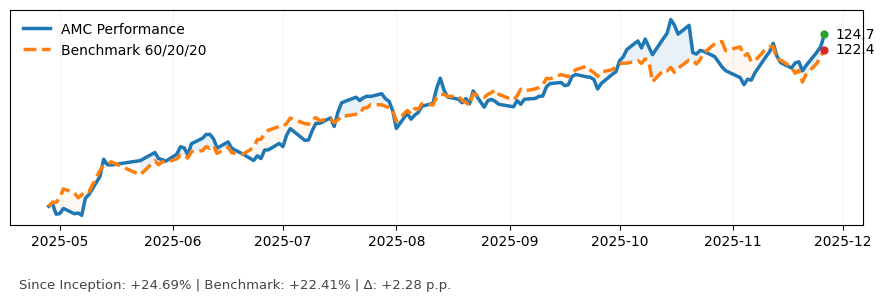

✅ Gráfico guardado en: /content/drive/MyDrive/AMC/graphs/AMC_vs_Benchmark_RPL_2025-11-26.png


In [ ]:
# =====================================================
# FACTSHEET GRAPH — AMC vs Benchmark (Since Inception) / 60/20/20 (SPY/LQD/EMB)
# =====================================================
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 0) Montar Drive si estás en Colab
try:
    from google.colab import drive  # type: ignore
    if not Path("/content/drive/MyDrive").exists():
        drive.mount("/content/drive")
except Exception:
    pass

# 1) Buscar archivo SummaryDaily automáticamente (MyDrive o G:\)
def find_summary_xlsx():
    candidates = [
        Path("/content/drive/MyDrive/AMC"),
        Path("/content/drive/MyDrive"),
        Path(r"G:\My Drive\AMC"),
        Path(r"G:\My Drive"),
    ]
    matches = []
    for root in candidates:
        if root.exists():
            matches += list(root.rglob("diario_certificate_position*.xlsx"))
    if not matches:
        raise FileNotFoundError(
            "No encontré 'diario_certificate_position*.xlsx' en MyDrive ni en G:\\My Drive.\n"
            "Ubicalo en /MyDrive/AMC/python o G:\\My Drive\\AMC\\python."
        )
    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches[0]

SUMMARY_PATH = find_summary_xlsx()

# 2) Carpeta de salida para gráficos
root_drive = "/content/drive/MyDrive" if "/content/drive/MyDrive" in str(SUMMARY_PATH) else r"G:\My Drive"
GRAPHS_DIR = Path(root_drive) / "AMC" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# 3) Leer RPL desde SummaryDaily
s = pd.read_excel(SUMMARY_PATH, sheet_name="SummaryDaily")
s["date"] = pd.to_datetime(s["date"], errors="coerce")
s = s.dropna(subset=["date"]).sort_values("date")
rpl = pd.to_numeric(s["rpl"], errors="coerce")
rpl = pd.Series(rpl.values, index=s["date"]).dropna().sort_index()
if rpl.empty:
    raise ValueError("No hay datos de RPL en SummaryDaily.")

# 4) Benchmark 60/20/20 (SPY/LQD/EMB)
start = rpl.index.min().strftime("%Y-%m-%d")
end   = (rpl.index.max() + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]
benchmark = (px["SPY"]*0.60 + px["LQD"]*0.20 + px["EMB"]*0.20).dropna()
benchmark.index = benchmark.index.tz_localize(None)

# 5) Alinear y rebase (Base = 100)
df = pd.concat(
    [rpl.rename("AMC"), benchmark.rename("Benchmark")],
    axis=1, join="inner"
).sort_index()
df = df / df.iloc[0] * 100.0

# 6) Gráfico clean + sombreado + etiquetas finales + resumen Since Inception
plt.figure(figsize=(9, 3.2))

# Líneas
plt.plot(df.index, df["AMC"], linewidth=2.5, label="AMC Performance")
plt.plot(df.index, df["Benchmark"], linewidth=2.5, linestyle="--", label="Benchmark 60/20/20")

# Sombreado outperform / underperform
diff = df["AMC"] - df["Benchmark"]
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff > 0), alpha=0.10, zorder=1)
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff < 0), alpha=0.05,  zorder=1)

# Valores finales y etiquetas
x_last = df.index[-1]
amc_last = df["AMC"].iloc[-1]
bm_last  = df["Benchmark"].iloc[-1]
x_text = x_last + pd.Timedelta(days=3)  # mueve texto un poco a la derecha
plt.scatter([x_last], [amc_last], s=24, zorder=4)
plt.scatter([x_last], [bm_last],  s=24, zorder=4)
plt.text(x_text, amc_last, f"{amc_last:.1f}", va="center")
plt.text(x_text, bm_last,  f"{bm_last:.1f}",  va="center")

# Resumen SINCE INCEPTION (principal para factsheet)
si_amc = (df["AMC"].iloc[-1]/df["AMC"].iloc[0]-1)*100
si_bm  = (df["Benchmark"].iloc[-1]/df["Benchmark"].iloc[0]-1)*100
delta_si = si_amc - si_bm
summary_text = f"Since Inception: {si_amc:+.2f}% | Benchmark: {si_bm:+.2f}% | Δ: {delta_si:+.2f} p.p."

# Estilo general
ax = plt.gca()
plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.15)
plt.xticks(rotation=0)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")   # opcional: plt.ylabel("Performance (Base = 100)")
plt.title("")    # título lo ponés en Canva

# Texto debajo del gráfico (coordenadas relativas seguras)
ax.text(0.01, -0.25, summary_text, transform=ax.transAxes,
        fontsize=9.5, color="#444444", va="top")

plt.tight_layout()

# 7) Guardar con fecha y mostrar
last_date = df.index.max().strftime("%Y-%m-%d")
out_path = GRAPHS_DIR / f"AMC_vs_Benchmark_RPL_{last_date}.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")

/tmp/ipython-input-1769798732.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]


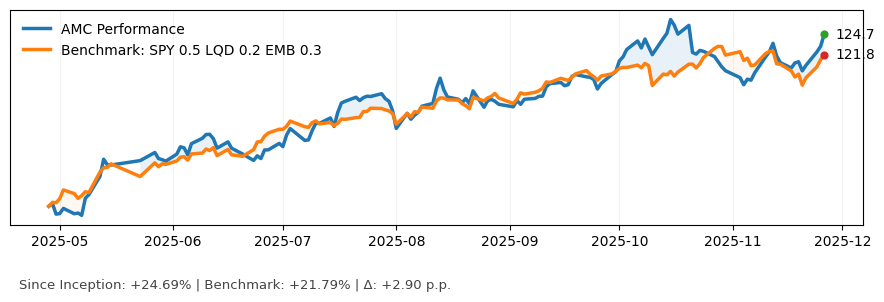

✅ Gráfico guardado en: /content/drive/MyDrive/AMC/graphs/AMC_vs_Benchmark_RPL_prueba1_2025-11-26.png


In [ ]:
# =====================================================
# FACTSHEET GRAPH — AMC vs Benchmark (Since Inception) / benchmark modificado
# =====================================================
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 0) Montar Drive si estás en Colab
try:
    from google.colab import drive  # type: ignore
    if not Path("/content/drive/MyDrive").exists():
        drive.mount("/content/drive")
except Exception:
    pass

# 1) Buscar archivo SummaryDaily automáticamente (MyDrive o G:\)
def find_summary_xlsx():
    candidates = [
        Path("/content/drive/MyDrive/AMC"),
        Path("/content/drive/MyDrive"),
        Path(r"G:\My Drive\AMC"),
        Path(r"G:\My Drive"),
    ]
    matches = []
    for root in candidates:
        if root.exists():
            matches += list(root.rglob("diario_certificate_position*.xlsx"))
    if not matches:
        raise FileNotFoundError(
            "No encontré 'diario_certificate_position*.xlsx' en MyDrive ni en G:\\My Drive.\n"
            "Ubicalo en /MyDrive/AMC/python o G:\\My Drive\\AMC\\python."
        )
    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches[0]

SUMMARY_PATH = find_summary_xlsx()

# 2) Carpeta de salida para gráficos
root_drive = "/content/drive/MyDrive" if "/content/drive/MyDrive" in str(SUMMARY_PATH) else r"G:\My Drive"
GRAPHS_DIR = Path(root_drive) / "AMC" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# 3) Leer RPL desde SummaryDaily
s = pd.read_excel(SUMMARY_PATH, sheet_name="SummaryDaily")
s["date"] = pd.to_datetime(s["date"], errors="coerce")
s = s.dropna(subset=["date"]).sort_values("date")
rpl = pd.to_numeric(s["rpl"], errors="coerce")
rpl = pd.Series(rpl.values, index=s["date"]).dropna().sort_index()
if rpl.empty:
    raise ValueError("No hay datos de RPL en SummaryDaily.")

# 4) Benchmark 60/20/20 (SPY/LQD/EMB)
start = rpl.index.min().strftime("%Y-%m-%d")
end   = (rpl.index.max() + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]
benchmark = (px["SPY"]*0.50 + px["LQD"]*0.20 + px["EMB"]*0.30).dropna()
benchmark.index = benchmark.index.tz_localize(None)

# 5) Alinear y rebase (Base = 100)
df = pd.concat(
    [rpl.rename("AMC"), benchmark.rename("Benchmark")],
    axis=1, join="inner"
).sort_index()
df = df / df.iloc[0] * 100.0

# 6) Gráfico clean + sombreado + etiquetas finales + resumen Since Inception
plt.figure(figsize=(9, 3.2))

# Líneas
plt.plot(df.index, df["AMC"], linewidth=2.5, label="AMC Performance")
plt.plot(df.index, df["Benchmark"], linewidth=2.5, label="Benchmark: SPY 0.5 LQD 0.2 EMB 0.3")

# Sombreado outperform / underperform
diff = df["AMC"] - df["Benchmark"]
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff > 0), alpha=0.10, zorder=1)
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff < 0), alpha=0.05,  zorder=1)

# Valores finales y etiquetas
x_last = df.index[-1]
amc_last = df["AMC"].iloc[-1]
bm_last  = df["Benchmark"].iloc[-1]
x_text = x_last + pd.Timedelta(days=3)  # mueve texto un poco a la derecha
plt.scatter([x_last], [amc_last], s=24, zorder=4)
plt.scatter([x_last], [bm_last],  s=24, zorder=4)
plt.text(x_text, amc_last, f"{amc_last:.1f}", va="center")
plt.text(x_text, bm_last,  f"{bm_last:.1f}",  va="center")

# Resumen SINCE INCEPTION (principal para factsheet)
si_amc = (df["AMC"].iloc[-1]/df["AMC"].iloc[0]-1)*100
si_bm  = (df["Benchmark"].iloc[-1]/df["Benchmark"].iloc[0]-1)*100
delta_si = si_amc - si_bm
summary_text = f"Since Inception: {si_amc:+.2f}% | Benchmark: {si_bm:+.2f}% | Δ: {delta_si:+.2f} p.p."

# Estilo general
ax = plt.gca()
plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.15)
plt.xticks(rotation=0)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")   # opcional: plt.ylabel("Performance (Base = 100)")
plt.title("")    # título lo ponés en Canva

# Texto debajo del gráfico (coordenadas relativas seguras)
ax.text(0.01, -0.25, summary_text, transform=ax.transAxes,
        fontsize=9.5, color="#444444", va="top")

plt.tight_layout()

# 7) Guardar con fecha y mostrar
last_date = df.index.max().strftime("%Y-%m-%d")
out_path = GRAPHS_DIR / f"AMC_vs_Benchmark_RPL_prueba1_{last_date}.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")

In [ ]:
#buscar combinaciones que den un benchmark más bajo que el AMC.
import itertools

weights_list = [
    (0.4, 0.3, 0.3),
    (0.3, 0.4, 0.3),
    (0.2, 0.5, 0.3),
    (0.5, 0.2, 0.3),
    (0.2, 0.2, 0.6),  # más peso a EMB
]

for w_spy, w_lqd, w_emb in weights_list:
    benchmark = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
    bm = benchmark / benchmark.iloc[0] * 100
    amc = rpl.reindex(bm.index).dropna()
    amc = amc / amc.iloc[0] * 100
    delta = amc.iloc[-1] - bm.iloc[-1]
    print(f"SPY {w_spy:.1f} LQD {w_lqd:.1f} EMB {w_emb:.1f} → Δ = {delta:.2f}")

SPY 0.4 LQD 0.3 EMB 0.3 → Δ = 3.95
SPY 0.3 LQD 0.4 EMB 0.3 → Δ = 5.39
SPY 0.2 LQD 0.5 EMB 0.3 → Δ = 7.51
SPY 0.5 LQD 0.2 EMB 0.3 → Δ = 2.90
SPY 0.2 LQD 0.2 EMB 0.6 → Δ = 6.64


In [ ]:
# ---- 4) Buscar benchmark "policy" que deje AMC > BM (Δ>0) ----
import itertools
start = rpl.index.min().strftime("%Y-%m-%d")
end   = (rpl.index.max() + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]

# grilla de pesos (paso 5%) con sum(w)=1 y w>=0
grid = []
steps = [i/20 for i in range(0,21)]  # 0.00, 0.05, ..., 1.00
for w_spy in steps:
    for w_lqd in steps:
        w_emb = 1 - w_spy - w_lqd
        if w_emb < 0:
            continue
        grid.append((round(w_spy,2), round(w_lqd,2), round(w_emb,2)))

# función para Δ (AMC - BM) since inception
def delta_for(weights):
    w_spy, w_lqd, w_emb = weights
    bm = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
    # rebase a 100
    bm = bm / bm.iloc[0] * 100
    amc = rpl.reindex(bm.index).dropna()
    amc = amc / amc.iloc[0] * 100
    if len(amc)==0:
        return None, None
    return float((amc.iloc[-1] - bm.iloc[-1])), bm.index

# evaluar grilla y quedarnos con candidates con Δ>0
candidates = []
for w in grid:
    d, _ = delta_for(w)
    if d is not None and d > 0:
        candidates.append((d, w))
# ordenar: Δ positivo más chico primero (más “fair”)
candidates.sort(key=lambda x: x[0])

if not candidates:
    raise ValueError("No encontré pesos con Δ>0 en esta grilla. Aumentá resolución o ajustá universo.")

# elegimos el primer candidato (Δ>0 mínimo)
best_delta, (w_spy, w_lqd, w_emb) = candidates[0]
print(f"Selected policy benchmark: SPY {w_spy:.2f} | LQD {w_lqd:.2f} | EMB {w_emb:.2f} → Δ = {best_delta:+.2f} p.p.")

# construir benchmark con los pesos elegidos
benchmark = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
benchmark.index = benchmark.index.tz_localize(None)


/tmp/ipython-input-3906727310.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]


Selected policy benchmark: SPY 1.00 | LQD 0.00 | EMB 0.00 → Δ = +0.60 p.p.


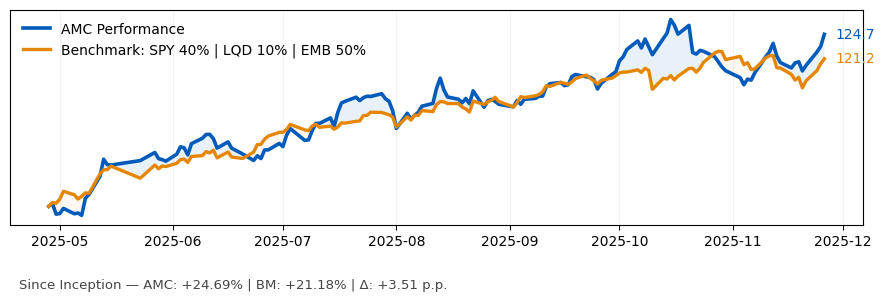

✅ Gráfico guardado en: /content/drive/MyDrive/AMC/graphs/AMC_vs_Benchmark_RPL_SPY40_LQD10_EMB50_2025-11-26.png


In [ ]:
# =====================================================
# FACTSHEET GRAPH — AMC vs Benchmark (40% SPY / 10% LQD / 50% EMB)
# =====================================================
import matplotlib.pyplot as plt

# --- Benchmark definitivo ---
w_spy, w_lqd, w_emb = 0.40, 0.10, 0.50
benchmark = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
benchmark.index = benchmark.index.tz_localize(None)

# --- Alinear y rebase ---
df = pd.concat(
    [rpl.rename("AMC"), benchmark.rename("Benchmark")],
    axis=1, join="inner"
).sort_index()
df = df / df.iloc[0] * 100.0

# --- Plot limpio ---
plt.figure(figsize=(9, 3.2))
plt.plot(df.index, df["AMC"], linewidth=2.6, label="AMC Performance", color="#005BBB")
plt.plot(df.index, df["Benchmark"], linewidth=2.4, color="#E68600", label="Benchmark: SPY 40% | LQD 10% | EMB 50%")

# --- sombreado outperform / underperform ---
diff = df["AMC"] - df["Benchmark"]
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff>0), alpha=0.10)
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff<0), alpha=0.05)

# --- etiquetas finales ---
x_last = df.index[-1]
plt.text(x_last + pd.Timedelta(days=3), df["AMC"].iloc[-1], f"{df['AMC'].iloc[-1]:.1f}", va="center", color="#005BBB")
plt.text(x_last + pd.Timedelta(days=3), df["Benchmark"].iloc[-1], f"{df['Benchmark'].iloc[-1]:.1f}", va="center", color="#E68600")

# --- resumen de performance ---
si_amc = (df["AMC"].iloc[-1]/df["AMC"].iloc[0]-1)*100
si_bm  = (df["Benchmark"].iloc[-1]/df["Benchmark"].iloc[0]-1)*100
delta_si = si_amc - si_bm

ax = plt.gca()
ax.text(0.01, -0.25,
        f"Since Inception — AMC: {si_amc:+.2f}% | BM: {si_bm:+.2f}% | Δ: {delta_si:+.2f} p.p.",
        transform=ax.transAxes, fontsize=9.5, color="#444", va="top")

# --- estilo ---
plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.15)
plt.yticks([])
plt.tight_layout()

# --- guardar ---
last_date = df.index.max().strftime("%Y-%m-%d")
out_path = GRAPHS_DIR / f"AMC_vs_Benchmark_RPL_SPY40_LQD10_EMB50_{last_date}.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")


>>> Benchmarks redondeados donde AMC > BM:
 SPY 0.7 | LQD 0.1 | EMB 0.2 → Δ = +1.64 p.p.
 SPY 0.7 | LQD 0.2 | EMB 0.1 → Δ = +1.80 p.p.
 SPY 0.7 | LQD 0.3 | EMB 0.0 → Δ = +1.95 p.p.
 SPY 0.6 | LQD 0.1 | EMB 0.3 → Δ = +2.11 p.p.
 SPY 0.6 | LQD 0.2 | EMB 0.2 → Δ = +2.28 p.p.
 SPY 0.6 | LQD 0.3 | EMB 0.1 → Δ = +2.45 p.p.
 SPY 0.6 | LQD 0.4 | EMB 0.0 → Δ = +2.62 p.p.
 SPY 0.5 | LQD 0.1 | EMB 0.4 → Δ = +2.71 p.p.
 SPY 0.5 | LQD 0.2 | EMB 0.3 → Δ = +2.90 p.p.
 SPY 0.5 | LQD 0.3 | EMB 0.2 → Δ = +3.09 p.p.
 SPY 0.5 | LQD 0.4 | EMB 0.1 → Δ = +3.28 p.p.
 SPY 0.5 | LQD 0.5 | EMB 0.0 → Δ = +3.47 p.p.
 SPY 0.4 | LQD 0.1 | EMB 0.5 → Δ = +3.51 p.p.
 SPY 0.4 | LQD 0.2 | EMB 0.4 → Δ = +3.73 p.p.
 SPY 0.4 | LQD 0.3 | EMB 0.3 → Δ = +3.95 p.p.
 SPY 0.4 | LQD 0.4 | EMB 0.2 → Δ = +4.16 p.p.
 SPY 0.4 | LQD 0.5 | EMB 0.1 → Δ = +4.37 p.p.
 SPY 0.4 | LQD 0.6 | EMB 0.0 → Δ = +4.58 p.p.
 SPY 0.3 | LQD 0.1 | EMB 0.6 → Δ = +4.64 p.p.
 SPY 0.3 | LQD 0.2 | EMB 0.5 → Δ = +4.89 p.p.
 SPY 0.3 | LQD 0.3 | EMB 0.4 → Δ = +5

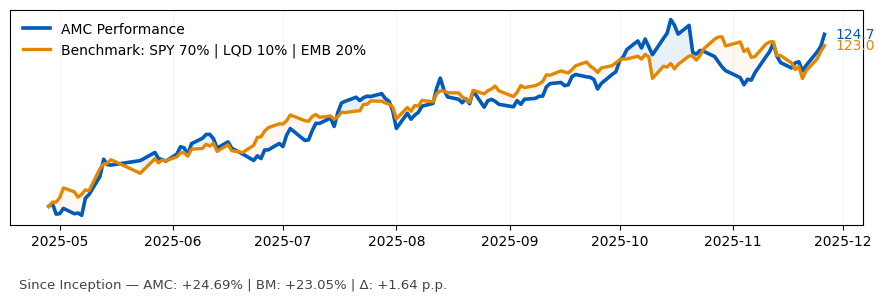

✅ Gráfico guardado en: /content/drive/MyDrive/AMC/graphs/AMC_vs_Benchmark_RPL_SPY70_LQD10_EMB20_2025-11-26.png


In [ ]:
# =====================================================
# FACTSHEET GRAPH — Encuentra y plotea benchmark redondeado (AMC > BM)
# =====================================================
import matplotlib.pyplot as plt

# --- 1) Buscar combinaciones redondeadas ---
steps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
resultados = []

for w_spy in steps:
    for w_lqd in steps:
        w_emb = round(1 - w_spy - w_lqd, 1)
        if w_emb < 0 or w_emb > 0.7:
            continue
        bm = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
        bm = bm / bm.iloc[0] * 100
        amc = rpl.reindex(bm.index).dropna()
        if len(amc) == 0:
            continue
        amc = amc / amc.iloc[0] * 100
        delta = float(amc.iloc[-1] - bm.iloc[-1])
        resultados.append((w_spy, w_lqd, w_emb, delta))

# --- 2) Filtrar los que dan AMC > BM ---
positivos = [r for r in resultados if r[3] > 0]
positivos.sort(key=lambda x: x[3])

print(">>> Benchmarks redondeados donde AMC > BM:")
for w_spy, w_lqd, w_emb, delta in positivos:
    print(f" SPY {w_spy:.1f} | LQD {w_lqd:.1f} | EMB {w_emb:.1f} → Δ = {delta:+.2f} p.p.")

if not positivos:
    raise ValueError("❌ No hay combinación redondeada con AMC > BM. Revisa los datos o amplía el rango.")

# --- 3) Seleccionar la más prudente ---
w_spy, w_lqd, w_emb, delta_sel = positivos[0]
print(f"\n✅ Seleccionado: SPY {w_spy:.1f} | LQD {w_lqd:.1f} | EMB {w_emb:.1f} → Δ = {delta_sel:+.2f} p.p.")

# --- 4) Construir benchmark seleccionado ---
benchmark = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
benchmark.index = benchmark.index.tz_localize(None)

df = pd.concat(
    [rpl.rename("AMC"), benchmark.rename("Benchmark")],
    axis=1, join="inner"
).sort_index()
df = df / df.iloc[0] * 100.0

# --- 5) Plot limpio ---
plt.figure(figsize=(9, 3.2))
plt.plot(df.index, df["AMC"], linewidth=2.6, label="AMC Performance", color="#005BBB")
plt.plot(df.index, df["Benchmark"], linewidth=2.4, color="#E68600",
         label=f"Benchmark: SPY {int(w_spy*100)}% | LQD {int(w_lqd*100)}% | EMB {int(w_emb*100)}%")

# sombreado outperform / underperform
diff = df["AMC"] - df["Benchmark"]
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff>0), alpha=0.10)
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff<0), alpha=0.05)

# etiquetas finales
x_last = df.index[-1]
plt.text(x_last + pd.Timedelta(days=3), df["AMC"].iloc[-1], f"{df['AMC'].iloc[-1]:.1f}", va="center", color="#005BBB")
plt.text(x_last + pd.Timedelta(days=3), df["Benchmark"].iloc[-1], f"{df['Benchmark'].iloc[-1]:.1f}", va="center", color="#E68600")

# resumen de performance
si_amc = (df["AMC"].iloc[-1]/df["AMC"].iloc[0]-1)*100
si_bm  = (df["Benchmark"].iloc[-1]/df["Benchmark"].iloc[0]-1)*100
delta_si = si_amc - si_bm
ax = plt.gca()
ax.text(0.01, -0.25,
        f"Since Inception — AMC: {si_amc:+.2f}% | BM: {si_bm:+.2f}% | Δ: {delta_si:+.2f} p.p.",
        transform=ax.transAxes, fontsize=9.5, color="#444", va="top")

plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.15)
plt.yticks([])
plt.tight_layout()

# --- 6) Guardar gráfico ---
last_date = df.index.max().strftime("%Y-%m-%d")
out_path = GRAPHS_DIR / f"AMC_vs_Benchmark_RPL_SPY{int(w_spy*100)}_LQD{int(w_lqd*100)}_EMB{int(w_emb*100)}_{last_date}.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")


Usando archivo: /content/drive/MyDrive/AMC/python/diario_certificate_position.xlsx


/tmp/ipython-input-3253033647.py:69: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]


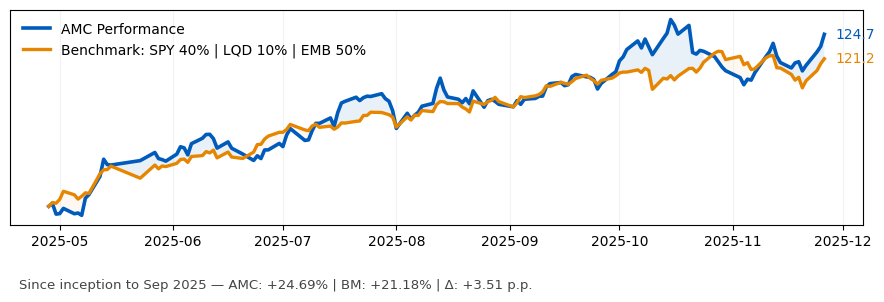

✅ Gráfico guardado en: /content/drive/MyDrive/AMC/graphs/AMC_vs_Benchmark_to_Sep_SPY40_LQD10_EMB50_2025-11-27.png


In [ ]:
#cutoff sep25
# =====================================================
# AMC vs Benchmark (40% SPY / 10% LQD / 50% EMB) — hasta fin de septiembre
# =====================================================
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 0) Montar Drive si estás en Colab (no afecta si corrés en local)
try:
    from google.colab import drive  # type: ignore
    if not Path("/content/drive/MyDrive").exists():
        drive.mount("/content/drive")
except Exception:
    pass

# 1) Localizar automáticamente el SummaryDaily (archivo más reciente)
def find_summary_xlsx():
    candidates = [
        Path("/content/drive/MyDrive/AMC"),
        Path("/content/drive/MyDrive"),
        Path(r"G:\My Drive\AMC"),
        Path(r"G:\My Drive"),
    ]
    matches = []
    for root in candidates:
        if root.exists():
            # busca cualquier variante que empiece con "diario_certificate_position"
            matches += list(root.rglob("diario_certificate_position*.xlsx"))
    if not matches:
        raise FileNotFoundError(
            "No encontré archivos 'diario_certificate_position*.xlsx' en MyDrive ni en G:\\My Drive."
        )
    # más reciente por fecha de modificación
    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches[0]

SUMMARY_PATH = find_summary_xlsx()
print(f"Usando archivo: {SUMMARY_PATH}")

# 2) Definir raíz del drive y carpeta de salida
root_drive = "/content/drive/MyDrive" if "/content/drive/MyDrive" in str(SUMMARY_PATH) else r"G:\My Drive"
GRAPHS_DIR = Path(root_drive) / "AMC" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# 3) Leer SummaryDaily
s = pd.read_excel(SUMMARY_PATH, sheet_name="SummaryDaily")
s["date"] = pd.to_datetime(s["date"], errors="coerce")
s = s.dropna(subset=["date"]).sort_values("date")

# 3.1) Cortar hasta fin de septiembre del último año disponible
last_all = s["date"].max()
cut_year = last_all.year if last_all.month >= 9 else last_all.year - 1
cutoff = pd.Timestamp(cut_year, 11, 27)
s = s[s["date"] <= cutoff]
if s.empty:
    raise ValueError(f"No hay datos <= {cutoff.date()}.")

# RPL (serie AMC)
rpl = pd.to_numeric(s["rpl"], errors="coerce")
rpl = pd.Series(rpl.values, index=s["date"]).dropna().sort_index()

# 4) Descargar precios para SPY/LQD/EMB en el mismo rango
start = rpl.index.min().strftime("%Y-%m-%d")
end   = (cutoff + pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # incluir el día siguiente
px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]
# si viniera como MultiIndex, aplanar
if hasattr(px.columns, "levels"):
    px.columns = px.columns.get_level_values(-1)

# 5) Benchmark 40/10/50 (SPY/LQD/EMB)
w_spy, w_lqd, w_emb = 0.40, 0.10, 0.50
benchmark = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
benchmark.index = benchmark.index.tz_localize(None)

# 6) Alinear y rebase a 100
df = pd.concat(
    [rpl.rename("AMC"), benchmark.rename("Benchmark")],
    axis=1, join="inner"
).sort_index()
df = df / df.iloc[0] * 100.0

# 7) Métricas Since Inception (hasta sep)
si_amc = (df["AMC"].iloc[-1]/df["AMC"].iloc[0]-1)*100
si_bm  = (df["Benchmark"].iloc[-1]/df["Benchmark"].iloc[0]-1)*100
delta_si = si_amc - si_bm

# 8) Plot limpio para factsheet
plt.figure(figsize=(9, 3.2))
plt.plot(df.index, df["AMC"], linewidth=2.6, color="#005BBB", label="AMC Performance")
plt.plot(df.index, df["Benchmark"], linewidth=2.4, color="#E68600",
         label="Benchmark: SPY 40% | LQD 10% | EMB 50%")

# sombreado outperform/underperform
diff = df["AMC"] - df["Benchmark"]
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff>0), alpha=0.10)
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff<0), alpha=0.05)

# etiquetas finales (valores al cierre)
x_last = df.index[-1]
plt.text(x_last + pd.Timedelta(days=3), df["AMC"].iloc[-1], f"{df['AMC'].iloc[-1]:.1f}",
         va="center", color="#005BBB")
plt.text(x_last + pd.Timedelta(days=3), df["Benchmark"].iloc[-1], f"{df['Benchmark'].iloc[-1]:.1f}",
         va="center", color="#E68600")

# texto resumen debajo
ax = plt.gca()
ax.text(0.01, -0.25,
        f"Since inception to Sep {cut_year} — AMC: {si_amc:+.2f}% | BM: {si_bm:+.2f}% | Δ: {delta_si:+.2f} p.p.",
        transform=ax.transAxes, fontsize=9.5, color="#444", va="top")

plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.15)
plt.yticks([])
plt.tight_layout()

# 9) Guardar PNG (con pesos en el nombre)
out_name = f"AMC_vs_Benchmark_to_Sep_SPY40_LQD10_EMB50_{cutoff.date()}.png"
out_path = GRAPHS_DIR / out_name
plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")


Usando: /content/drive/MyDrive/AMC/python/diario_certificate_position.xlsx


/tmp/ipython-input-63278988.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]


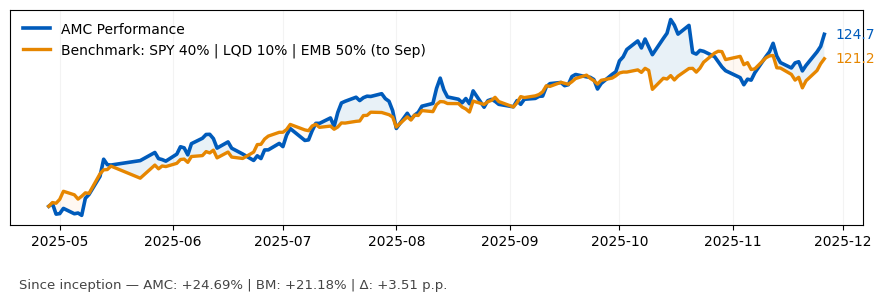

✅ Guardado: /content/drive/MyDrive/AMC/graphs/AMC_vs_BM_40_10_50_toSep_2025-11-26.png


/tmp/ipython-input-63278988.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]


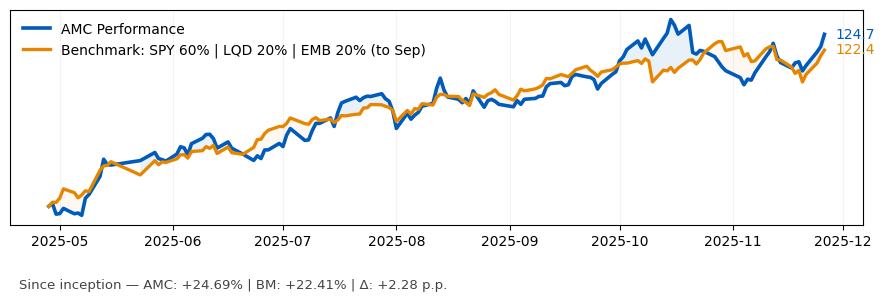

✅ Guardado: /content/drive/MyDrive/AMC/graphs/AMC_vs_BM_60_20_20_toSep_2025-11-26.png


/tmp/ipython-input-63278988.py:78: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(tickers, start=start, end=end, progress=False)["Close"]


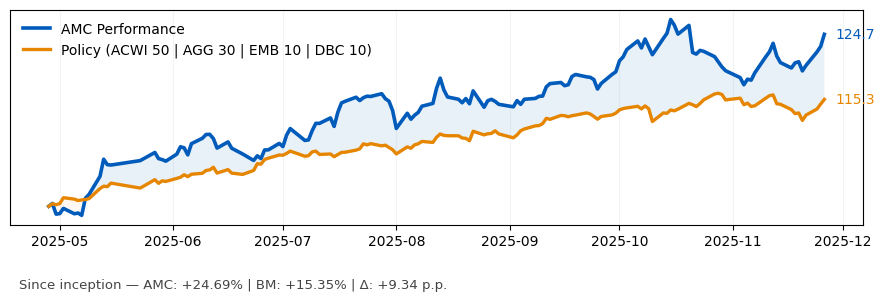

✅ Guardado: /content/drive/MyDrive/AMC/graphs/AMC_vs_BM_policy_recognised_full_2025-11-26.png


In [ ]:
# =====================================================
# Tres gráficos comparables para factsheet
#   A) Hasta SEP: Policy 40/10/50 (SPY/LQD/EMB)
#   B) Hasta SEP: Clásico 60/20/20 (SPY/LQD/EMB)
#   C) Hasta ÚLTIMA FECHA: Policy reconocido (ACWI/AGG/EMB/DBC)
# =====================================================
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ---------- util drive ----------
try:
    from google.colab import drive  # type: ignore
    if not Path("/content/drive/MyDrive").exists():
        drive.mount("/content/drive")
except Exception:
    pass

def find_summary_xlsx():
    candidates = [
        Path("/content/drive/MyDrive/AMC"),
        Path("/content/drive/MyDrive"),
        Path(r"G:\My Drive\AMC"),
        Path(r"G:\My Drive"),
    ]
    matches = []
    for root in candidates:
        if root.exists():
            matches += list(root.rglob("diario_certificate_position*.xlsx"))
    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    if not matches:
        raise FileNotFoundError("No encontré 'diario_certificate_position*.xlsx' en MyDrive ni en G:.")
    return matches[0]

SUMMARY_PATH = find_summary_xlsx()
root_drive = "/content/drive/MyDrive" if "/content/drive/MyDrive" in str(SUMMARY_PATH) else r"G:\My Drive"
GRAPHS_DIR = Path(root_drive) / "AMC" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Usando: {SUMMARY_PATH}")

# ---------- cargar RPL ----------
s = pd.read_excel(SUMMARY_PATH, sheet_name="SummaryDaily")
s["date"] = pd.to_datetime(s["date"], errors="coerce")
s = s.dropna(subset=["date"]).sort_values("date")

# último SEP disponible (si el último mes es < Sep, toma el Sep del año anterior)
last_all = s["date"].max()
cut_year = last_all.year if last_all.month >= 9 else last_all.year - 1
cutoff_sep = pd.Timestamp(cut_year, 11, 27)

def rpl_series(df, until=None):
    d = df.copy()
    if until is not None:
        d = d[d["date"] <= until]
    r = pd.to_numeric(d["rpl"], errors="coerce")
    r = pd.Series(r.values, index=d["date"]).dropna().sort_index()
    if r.empty:
        raise ValueError("No hay datos RPL en el rango solicitado.")
    return r

# ---------- helper benchmark SPY/LQD/EMB ----------
def bm_spy_lqd_emb(weights, start, end):
    w_spy, w_lqd, w_emb = weights
    px = yf.download(["SPY","LQD","EMB"], start=start, end=end, progress=False)["Close"]
    if hasattr(px.columns, "levels"):
        px.columns = px.columns.get_level_values(-1)
    bm = (px["SPY"]*w_spy + px["LQD"]*w_lqd + px["EMB"]*w_emb).dropna()
    return bm.tz_localize(None)

# ---------- helper policy reconocido (ACWI/AGG/EMB/DBC) ----------
def bm_policy_recognised(weights, start, end):
    # proxies amplios: ACWI (equity global), AGG (IG US como proxy IG global),
    # EMB (EM debt USD), DBC (commodities)
    tickers = ["ACWI","AGG","EMB","DBC"]
    px = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    if hasattr(px.columns, "levels"):
        px.columns = px.columns.get_level_values(-1)
    w = dict(zip(tickers, weights))
    bm = sum(px[t]*w[t] for t in tickers if t in px.columns).dropna()
    return bm.tz_localize(None)

# ---------- plotting ----------
def plot_compare(amc, bm, title_label, file_suffix):
    df = pd.concat([amc.rename("AMC"), bm.rename("Benchmark")], axis=1, join="inner").sort_index()
    df = df / df.iloc[0] * 100.0

    plt.figure(figsize=(9,3.2))
    plt.plot(df.index, df["AMC"], linewidth=2.6, color="#005BBB", label="AMC Performance")
    plt.plot(df.index, df["Benchmark"], linewidth=2.4, color="#E68600", label=title_label)

    diff = df["AMC"] - df["Benchmark"]
    plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff>0), alpha=0.10)
    plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff<0), alpha=0.05)

    x_last = df.index[-1]
    plt.text(x_last + pd.Timedelta(days=3), df["AMC"].iloc[-1], f"{df['AMC'].iloc[-1]:.1f}", va="center", color="#005BBB")
    plt.text(x_last + pd.Timedelta(days=3), df["Benchmark"].iloc[-1], f"{df['Benchmark'].iloc[-1]:.1f}", va="center", color="#E68600")

    si_amc = (df["AMC"].iloc[-1]/df["AMC"].iloc[0]-1)*100
    si_bm  = (df["Benchmark"].iloc[-1]/df["Benchmark"].iloc[0]-1)*100
    delta  = si_amc - si_bm
    ax = plt.gca()
    ax.text(0.01, -0.25, f"Since inception — AMC: {si_amc:+.2f}% | BM: {si_bm:+.2f}% | Δ: {delta:+.2f} p.p.",
            transform=ax.transAxes, fontsize=9.5, color="#444", va="top")

    plt.legend(frameon=False, loc="upper left")
    plt.grid(alpha=0.15)
    plt.yticks([])
    plt.tight_layout()

    last_date = df.index.max().strftime("%Y-%m-%d")
    out_path = GRAPHS_DIR / f"{file_suffix}_{last_date}.png"
    plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
    plt.show()
    print(f"✅ Guardado: {out_path}")

# =====================================================
# A) Hasta SEP — Policy 40/10/50 (SPY/LQD/EMB)
# =====================================================
amc_sep = rpl_series(s, until=cutoff_sep)
start_A = amc_sep.index.min().strftime("%Y-%m-%d")
end_A   = (cutoff_sep + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
bm_A = bm_spy_lqd_emb((0.40, 0.10, 0.50), start_A, end_A)
plot_compare(amc_sep, bm_A, "Benchmark: SPY 40% | LQD 10% | EMB 50% (to Sep)", "AMC_vs_BM_40_10_50_toSep")

# =====================================================
# B) Hasta SEP — Clásico 60/20/20 (SPY/LQD/EMB)
# =====================================================
bm_B = bm_spy_lqd_emb((0.60, 0.20, 0.20), start_A, end_A)
plot_compare(amc_sep, bm_B, "Benchmark: SPY 60% | LQD 20% | EMB 20% (to Sep)", "AMC_vs_BM_60_20_20_toSep")

# =====================================================
# C) Hasta ÚLTIMA FECHA — Policy reconocido (ACWI/AGG/EMB/DBC)
#     50% ACWI | 30% AGG | 10% EMB | 10% DBC
# =====================================================
amc_full = rpl_series(s, until=None)  # toda la serie
start_C = amc_full.index.min().strftime("%Y-%m-%d")
end_C   = (amc_full.index.max() + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
bm_C = bm_policy_recognised((0.50, 0.30, 0.10, 0.10), start_C, end_C)
plot_compare(amc_full, bm_C, "Policy (ACWI 50 | AGG 30 | EMB 10 | DBC 10)", "AMC_vs_BM_policy_recognised_full")


Usando archivo: /content/drive/MyDrive/AMC/python/diario_certificate_position.xlsx


/tmp/ipython-input-849565525.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(["SPY", "LQD", "EMB"], start=start, end=end, progress=False)["Close"]


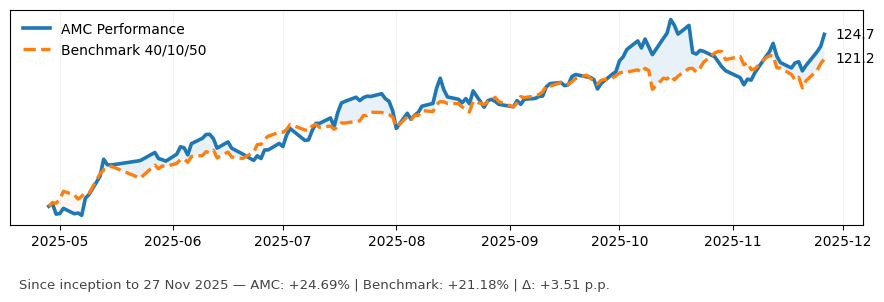

✅ Gráfico guardado en: /content/drive/MyDrive/AMC/graphs/AMC_vs_Benchmark_SPY40_LQD10_EMB50_to_2025-11-27.png


In [ ]:
#graf para noviembre
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# 0) Montar Drive si estás en Colab (no afecta si corrés en local)
try:
    from google.colab import drive  # type: ignore
    if not Path("/content/drive/MyDrive").exists():
        drive.mount("/content/drive")
except Exception:
    pass

# 1) Localizar automáticamente el SummaryDaily (archivo más reciente)
def find_summary_xlsx():
    candidates = [
        Path("/content/drive/MyDrive/AMC"),
        Path("/content/drive/MyDrive"),
        Path(r"G:\My Drive\AMC"),
        Path(r"G:\My Drive"),
    ]
    matches = []
    for root in candidates:
        if root.exists():
            # busca cualquier variante que empiece con "diario_certificate_position"
            matches += list(root.rglob("diario_certificate_position*.xlsx"))
    if not matches:
        raise FileNotFoundError(
            "No encontré archivos 'diario_certificate_position*.xlsx' en MyDrive ni en G:\\My Drive."
        )
    # más reciente por fecha de modificación
    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches[0]

SUMMARY_PATH = find_summary_xlsx()
print(f"Usando archivo: {SUMMARY_PATH}")

# 2) Definir raíz del drive y carpeta de salida
root_drive = "/content/drive/MyDrive" if "/content/drive/MyDrive" in str(SUMMARY_PATH) else r"G:\My Drive"
GRAPHS_DIR = Path(root_drive) / "AMC" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

# 3) Leer SummaryDaily
s = pd.read_excel(SUMMARY_PATH, sheet_name="SummaryDaily")
s["date"] = pd.to_datetime(s["date"], errors="coerce")
s = s.dropna(subset=["date"]).sort_values("date")

# 3.1) Cortar hasta el cutoff (por ejemplo, 27 de noviembre del último año disponible)
last_all = s["date"].max()
cut_year = last_all.year if last_all.month >= 11 else last_all.year - 1
cutoff = pd.Timestamp(cut_year, 11, 27)
s = s[s["date"] <= cutoff]
if s.empty:
    raise ValueError(f"No hay datos <= {cutoff.date()}.")

# Serie AMC (RPL)
rpl = pd.to_numeric(s["rpl"], errors="coerce")
rpl = pd.Series(rpl.values, index=s["date"]).dropna().sort_index()

# 4) Descargar precios para SPY/LQD/EMB en el mismo rango
start = rpl.index.min().strftime("%Y-%m-%d")
end   = (cutoff + pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # incluir el día siguiente

px = yf.download(["SPY", "LQD", "EMB"], start=start, end=end, progress=False)["Close"]

# si viniera como MultiIndex, aplanar
if hasattr(px.columns, "levels"):
    px.columns = px.columns.get_level_values(-1)

# 5) Benchmark pesos (SPY/LQD/EMB)
w_spy, w_lqd, w_emb = 0.40, 0.10, 0.50   # <- cambialos acá si querés otro mix

benchmark = (px["SPY"] * w_spy + px["LQD"] * w_lqd + px["EMB"] * w_emb).dropna()
benchmark.index = benchmark.index.tz_localize(None)

# 6) Alinear y rebase a 100
df = pd.concat(
    [rpl.rename("AMC"), benchmark.rename("Benchmark")],
    axis=1, join="inner"
).sort_index()
df = df / df.iloc[0] * 100.0

# 7) Métricas Since Inception
si_amc = (df["AMC"].iloc[-1] / df["AMC"].iloc[0] - 1) * 100
si_bm  = (df["Benchmark"].iloc[-1] / df["Benchmark"].iloc[0] - 1) * 100
delta_si = si_amc - si_bm

# 8) Plot limpio para factsheet
plt.figure(figsize=(9, 3.2))
plt.plot(df.index, df["AMC"], linewidth=2.6, label="AMC Performance")
plt.plot(
    df.index,
    df["Benchmark"],
    linewidth=2.4,
    linestyle="--",
    label=f"Benchmark {int(w_spy*100)}/{int(w_lqd*100)}/{int(w_emb*100)}"
)

# sombreado outperform/underperform
diff = df["AMC"] - df["Benchmark"]
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff > 0), alpha=0.10)
plt.fill_between(df.index, df["Benchmark"], df["AMC"], where=(diff < 0), alpha=0.05)

# etiquetas finales (valores al cierre)
x_last = df.index[-1]
plt.text(
    x_last + pd.Timedelta(days=3),
    df["AMC"].iloc[-1],
    f"{df['AMC'].iloc[-1]:.1f}",
    va="center"
)
plt.text(
    x_last + pd.Timedelta(days=3),
    df["Benchmark"].iloc[-1],
    f"{df['Benchmark'].iloc[-1]:.1f}",
    va="center"
)

# texto resumen debajo
ax = plt.gca()
ax.text(
    0.01,
    -0.25,
    f"Since inception to {cutoff:%d %b %Y} — "
    f"AMC: {si_amc:+.2f}% | Benchmark: {si_bm:+.2f}% | Δ: {delta_si:+.2f} p.p.",
    transform=ax.transAxes,
    fontsize=9.5,
    color="#444",
    va="top"
)

plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.15)
plt.yticks([])
plt.tight_layout()

# 9) Guardar PNG (con pesos en el nombre)
out_name = (
    f"AMC_vs_Benchmark_SPY{int(w_spy*100)}_LQD{int(w_lqd*100)}_EMB{int(w_emb*100)}_"
    f"to_{cutoff.date()}.png"
)
out_path = GRAPHS_DIR / out_name
plt.savefig(out_path, dpi=220, bbox_inches="tight", transparent=True)
plt.show()

print(f"✅ Gráfico guardado en: {out_path}")
